<a href="https://colab.research.google.com/github/kvame96/NOVIA/blob/main/%22Industrial_AI%22_CHESS_2_linrock_chessboard_recognizer_Automated_via_LangGraph_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size: 4em;">Second Model</h1>

The model is fed with a PNG of an online chessboard.\
The vision agent takes the PNG as input and outputs a fen of the chessboard.\
The strategy agent suggests the next move.\
Orchestration by LangGraph.

In [1]:
%%capture
%reset -f

# 🧠 Requirements (exact from second code):
!pip install tensorflow==2.12.0 torch torchvision opencv-python pillow tqdm langgraph langchain-core python-chess cairosvg matplotlib requests gitpython


import os
import subprocess
import requests
import re
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda

In [2]:
# 1️⃣ Define the state schema
class ChessState(TypedDict):
    image_url: str
    image_path: Optional[str]
    fen: Optional[str]
    board: Optional[object]

################################################################################

# 2️⃣ Define the steps

def install_dependencies(state: ChessState) -> ChessState:
    # Already installed above with pip in %%capture cell, no-op here to avoid reinstalling
    return state

def clone_repo(state: ChessState) -> ChessState:
    # Remove old repo folder and clone fresh, exactly like second code
    if os.path.exists("chessboard-recognizer"):
        subprocess.run(["rm", "-rf", "chessboard-recognizer"])
    subprocess.run(["git", "clone", "https://github.com/linrock/chessboard-recognizer.git"], check=True)
    return state

def download_model_weights(state: ChessState) -> ChessState:
    # Download nn.zip to parent directory exactly as second code
    if not os.path.exists("nn.zip"):
        subprocess.run(["wget", "https://github.com/linrock/chessboard-recognizer/releases/download/v0.5/nn.zip"], check=True)
    return state

def unzip_model(state: ChessState) -> ChessState:
    # Remove any existing nn folder and unzip exactly as second code
    if os.path.exists("chessboard-recognizer/nn"):
        subprocess.run(["rm", "-rf", "chessboard-recognizer/nn"], check=True)
    subprocess.run(["unzip", "-o", "nn.zip", "-d", "chessboard-recognizer"], check=True)
    return state

def download_image(state: ChessState) -> ChessState:
    image_path = "input.png"
    # Always re-download the image (overwrite)
    response = requests.get(state["image_url"])
    with open(image_path, "wb") as f:
        f.write(response.content)
    state["image_path"] = image_path
    return state

def recognize_fen(state: ChessState) -> ChessState:
    repo_dir = "chessboard-recognizer"
    if not os.path.exists(repo_dir):
        raise FileNotFoundError(f"Expected repo dir '{repo_dir}' not found")

    # Save current directory
    current_dir = os.getcwd()
    os.chdir(repo_dir)

    try:
        # Run recognize.py exactly as in second code on image at ../input.png
        result = subprocess.run(
            ['python3', 'recognize.py', os.path.join("..", state["image_path"])],
            capture_output=True, text=True, check=True
        )
        output = result.stdout
    finally:
        os.chdir(current_dir)

    # Extract FEN using regex exactly as second code
    fen_pattern = re.compile(
        r"^([rnbqkpRNBQKP1-8]+\/){7}[rnbqkpRNBQKP1-8]+ [wb] (-|K?Q?k?q?) (-|[a-h][36]) \d+ \d+$"
    )

    fen_lines = [line.strip() for line in output.splitlines() if fen_pattern.match(line.strip())]

    if fen_lines:
        fen = fen_lines[-1]
    else:
        lines = [line.strip() for line in output.splitlines() if line.strip()]
        fen = lines[-1] + " w KQkq - 0 1"

    print("Extracted FEN:", fen)
    state["fen"] = fen
    return state

def render_board(state: ChessState) -> ChessState:
    import chess
    import chess.svg
    import cairosvg
    import matplotlib.pyplot as plt
    import io
    from PIL import Image

    board = chess.Board(state["fen"])
    state["board"] = board

    svg_data = chess.svg.board(board=board)
    png_data = cairosvg.svg2png(bytestring=svg_data)

    img = Image.open(io.BytesIO(png_data))
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Board that the Vision Agent outputs (PNG to FEN)")
    plt.show()

    return state

def run_stockfish(state: ChessState) -> ChessState:
    import chess.engine
    import chess.svg
    import cairosvg
    import matplotlib.pyplot as plt
    import io
    from PIL import Image

    subprocess.run(["apt-get", "install", "-y", "stockfish"], check=True)
    engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")

    result = engine.play(state["board"], chess.engine.Limit(time=1.0))
    print("Best move:", result.move)
    state["board"].push(result.move)

    svg_data_after = chess.svg.board(board=state["board"])
    png_data_after = cairosvg.svg2png(bytestring=svg_data_after)

    img_after = Image.open(io.BytesIO(png_data_after))
    plt.figure(figsize=(6, 6))
    plt.imshow(img_after)
    plt.axis("off")
    plt.title("Board After Stockfish Move")
    plt.show()

    engine.quit()
    return state

🔗 Please enter the URL of the chessboard image: https://github.com/kvame96/chess-board-images/blob/main/Game_A_030.PNG?raw=true


## **Screenshot / PNG taken by you**

Extracted FEN: 3r1k2/pp3Pp1/2p4p/4p3/3qN3/8/P5PP/4QR1K w KQkq - 0 1


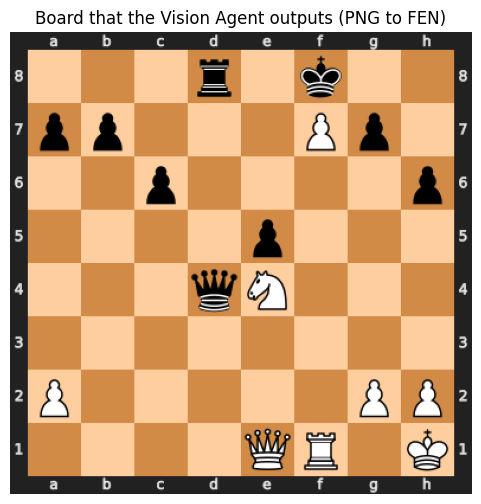

Best move: e1c1


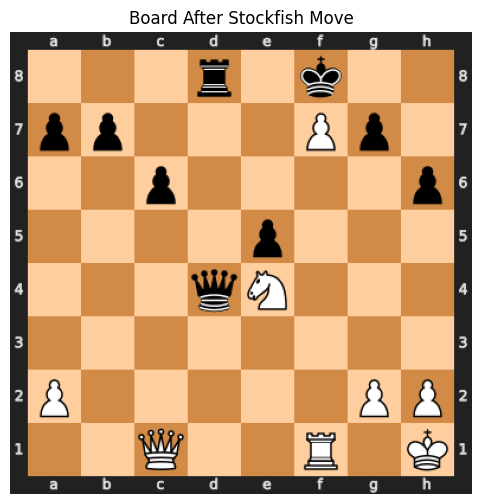

{'image_url': 'https://github.com/kvame96/chess-board-images/blob/main/Game_A_030.PNG?raw=true',
 'image_path': 'input.png',
 'fen': '3r1k2/pp3Pp1/2p4p/4p3/3qN3/8/P5PP/4QR1K w KQkq - 0 1',
 'board': Board('3r1k2/pp3Pp1/2p4p/4p3/3qN3/8/P5PP/2Q2R1K b - - 1 1')}

In [3]:
from IPython.display import Image as IPImage, display, Markdown

# Ask the user for a URL
user_image_url = input("🔗 Please enter the URL of the chessboard image: ")

# Display the image directly from the URL
display(Markdown("## **Screenshot / PNG taken by you**"))
display(IPImage(url=user_image_url, width=400, height=400))

# Define the initial state dynamically from user input
initial_state: ChessState = {
    "image_url": user_image_url,
    "image_path": None,
    "fen": None,
    "board": None
}

################################################################################

# Build the LangGraph with nodes exactly from above functions

graph = StateGraph(ChessState)

graph.add_node("install_dependencies", RunnableLambda(install_dependencies))
graph.add_node("clone_repo", RunnableLambda(clone_repo))
graph.add_node("download_model_weights", RunnableLambda(download_model_weights))
graph.add_node("unzip_model", RunnableLambda(unzip_model))
graph.add_node("download_image", RunnableLambda(download_image))
graph.add_node("recognize_fen", RunnableLambda(recognize_fen))
graph.add_node("render_board", RunnableLambda(render_board))
graph.add_node("run_stockfish", RunnableLambda(run_stockfish))

graph.set_entry_point("install_dependencies")
graph.add_edge("install_dependencies", "clone_repo")
graph.add_edge("clone_repo", "download_model_weights")
graph.add_edge("download_model_weights", "unzip_model")
graph.add_edge("unzip_model", "download_image")
graph.add_edge("download_image", "recognize_fen")
graph.add_edge("recognize_fen", "render_board")
graph.add_edge("render_board", "run_stockfish")
graph.add_edge("run_stockfish", END)

app = graph.compile()

# 4️⃣ Run the graph pipeline!
app.invoke(initial_state)

# Link to GitHub to the chess board:
# board form GitHub: "https://github.com/kvame96/chess-board-images/blob/main/Game_A_001.PNG?raw=true"